This project is implementation of Blind Colour Decomposition.
Images used are from kaggle lung and colon dataset

In [254]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading image and storing in requisite format

Enter the number of tissues/components2


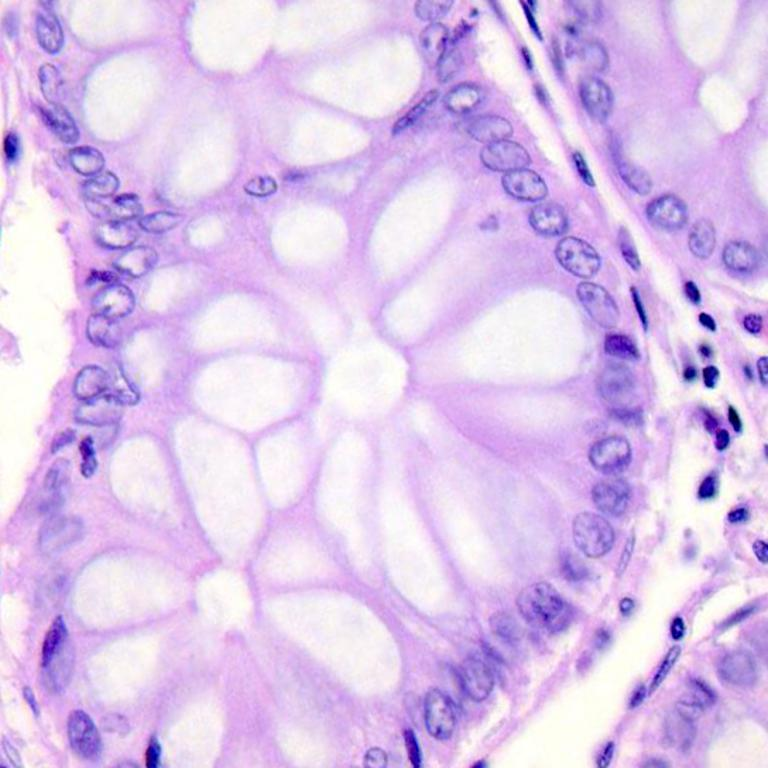

In [255]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import math
import cv2
import numpy as np
import math
#Enter the number of components in the image
num_components=int(input('Enter the number of tissues/components'))
image=cv2.imread('/content/drive/MyDrive/16.jpeg')
r=[]
g=[]
b=[]
for i in range(image.shape[0]):
  for j in range(image.shape[1]):
    r.append(image[i][j][0])
    g.append(image[i][j][1])
    b.append(image[i][j][2])
r=np.array(r)
g=np.array(g)
b=np.array(b)
cv2_imshow(image)

Projection on Beer Lamberts plane

In [256]:
r=-(np.log(r)-math.log(255))
g=-(np.log(g)-math.log(255))
b=-(np.log(b)-math.log(255))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


Projection on Maxwell chromaticity plane

In [257]:
A=np.array([[1/math.sqrt(2),-1/math.sqrt(2),0],
            [-1/math.sqrt(6),-1/math.sqrt(6),math.sqrt(2/3)]])
lab=np.vstack((np.vstack((r,g)),b))
lab_final=np.copy(lab)
for i in range(lab.shape[1]):
  lab[:,i]/=np.linalg.norm(lab[:,i],ord=1)
ab=np.dot(A,lab)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


Scatter plot of image on alpha-beta plane

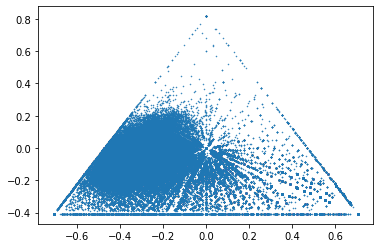

In [258]:
plt.scatter(ab[0],ab[1],s=0.25)
plt.savefig('/content/drive/MyDrive/scatter_plot.jpeg', dpi=400)
plt.show()

Apply Gaussian mixture model

In [259]:
ab=ab.transpose()
check=lambda a:not (math.isnan(a[0]) or math.isnan(a[0]) or math.isnan(a[0]))
ab=[value for value in ab if check(value)]
data=np.copy(np.array(ab))
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=num_components)
gmm.fit(ab)
print('GMM means\n',gmm.means_)
print('\n\n GMM covarince matrices\n',gmm.covariances_)

GMM means
 [[ 0.00415042 -0.18360297]
 [-0.29070997 -0.05659513]]


 GMM covarince matrices
 [[[ 0.09461085 -0.01409137]
  [-0.01409137  0.01858019]]

 [[ 0.00695378  0.00169961]
  [ 0.00169961  0.00409694]]]


Scatter plot showing the GMM cluster centres

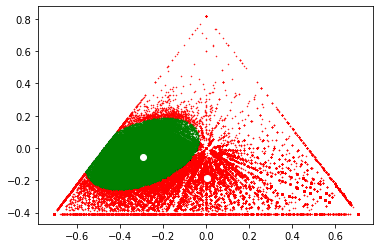

In [260]:
import pandas as pd
alpha=gmm.means_[:,0]
beta=gmm.means_[:,1]
ab=np.array(ab).transpose()
labels = gmm.predict(data)
frame = pd.DataFrame(data)
frame['cluster'] = labels
frame.columns = ['Weight', 'Height', 'cluster']
color=['r','g','b','c','m','y','k']
for k in range(min(num_components,len(color))):
    data = frame[frame["cluster"]==k]
    plt.scatter(data["Weight"],data["Height"],c=color[k],s=0.25)
plt.scatter(alpha,beta,c='w')
plt.savefig('/content/drive/MyDrive/scatter_plot_after_gmm.jpeg', dpi=400)
plt.show()

Transforming reference colour

In [261]:
B=np.array([[1/2**0.5,-1/6**0.5,1/3],
            [-1/2**0.5,-1/6**0.5,1/3],
            [0,(2/3)**0.5,1/3]])
X=np.hstack((gmm.means_,np.ones((num_components,1))))
a=np.dot(B,X.transpose())
print(a)

[[0.41122372 0.15087521]
 [0.40535415 0.56200119]
 [0.18342214 0.2871236 ]]


Computing the density map

In [262]:
density_map=np.dot(np.linalg.pinv(a),lab_final)

Segregating image based on density map obtained

Tissue Type  1 






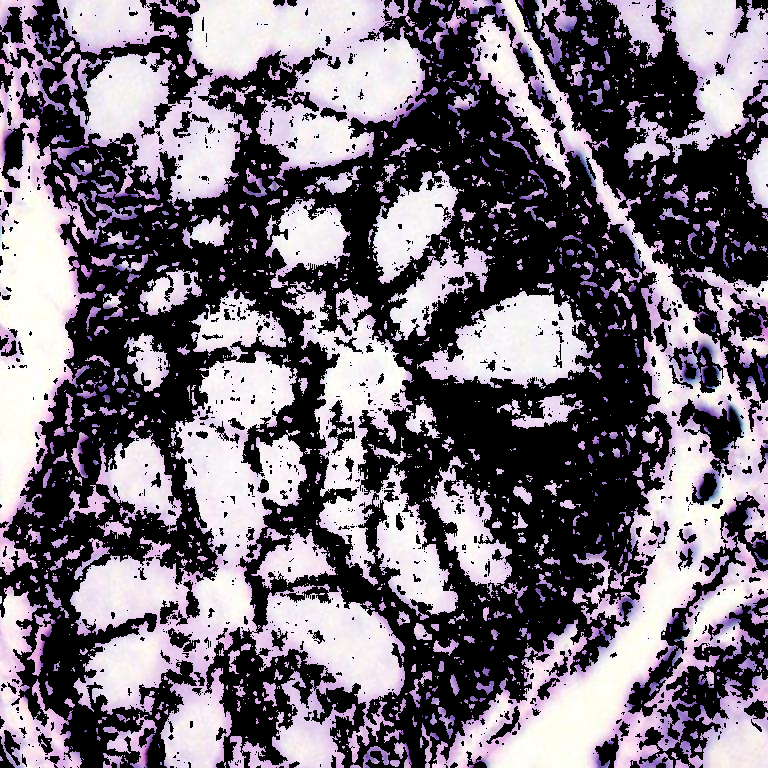

Tissue Type  2 






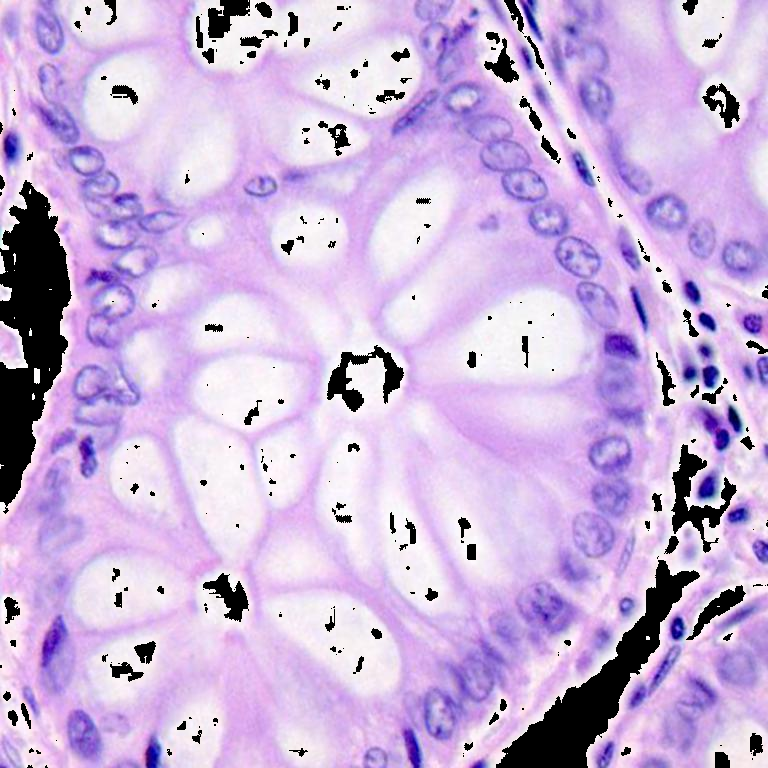

In [263]:
tissues=[np.copy(image) for i in range(density_map.shape[0])]
for tissue in range(density_map.shape[0]):
  for i in range(image.shape[0]):
    for j in range(image.shape[1]):
      if density_map.transpose()[i*image.shape[1]+j,tissue]<0:
        tissues[tissue][i][j]=[0,0,0]
for i,tissue in enumerate(tissues):
  print('Tissue Type ',i+1,'\n'*4)
  cv2_imshow(tissue)
  cv2.imwrite('/content/drive/MyDrive/tissue_type_'+str(i+1)+'.jpeg',tissue)